In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append("../../../XRaySimulation2")

from XRaySimulation import util
import scipy.signal as sps

import matplotlib
from matplotlib.colors import LogNorm

matplotlib.rcParams['font.family'] = ['serif']
matplotlib.rcParams['font.size'] = 12

# Explanation
The illumination volume is contains in a region of 
20 um x 40 um x 100 um  (x, y, z)
Therefore, I can create a box with resolution of 1um along each axis
Then, I will calculate if this pixel is illuminated.
Then, I will calculate along the z axis, how many TG periods are in the illumination volume
Then, I'll calculate the mean TG period number

In [2]:
def add_weight_cylinder(start, direction, fwhm_xy, space, attenuation_length_um, surface_point, surface_normal,
                        beam_attenaution=False):
    # Get the distance
    l_pixel = (space - surface_point[np.newaxis, np.newaxis, np.newaxis, :])
    l_pixel = np.dot(l_pixel, surface_normal)
    l_pixel /= np.dot(direction, surface_normal)

    # Get a mask such that we only keep the pixel inside the surface
    sample_mask = (l_pixel >= 0)

    # Get a mask that only consider space inside the cylinder
    displacement = (space - start[np.newaxis, np.newaxis, np.newaxis, :])
    deviation = displacement - np.multiply(np.dot(displacement, direction)[:, :, :, np.newaxis],
                                           direction[np.newaxis, np.newaxis, np.newaxis, :])
    displacement_x = deviation[:, :, :, 0]
    displacement_yz = np.sqrt(deviation[:, :, :, 1] ** 2 + deviation[:, :, :, 2] ** 2)

    # Check if the pixel is within the volume of illumination
    x_ray_mask = (displacement_x ** 2 / fwhm_xy[0] ** 2 + displacement_yz ** 2 / fwhm_xy[1] ** 2 - 1 <= 0)
    total_mask = np.multiply(sample_mask, x_ray_mask)

    # Add the weight according to the attenuation coefficient
    weight = np.zeros_like(displacement_x, dtype=np.float64)
    weight[total_mask] = np.exp(-l_pixel[total_mask] / attenuation_length_um)

    if beam_attenaution:
        print("Get get the weight assuming a Gaussian X-ray profile")
        sigma_x = util.fwhm_to_sigma(fwhm=fwhm_xy[0])
        sigma_y = util.fwhm_to_sigma(fwhm=fwhm_xy[1])

        weight *= np.exp(- displacement_x ** 2 / sigma_x ** 2 / 2) / np.sqrt(np.pi * 2) / sigma_x
        weight *= np.exp(- displacement_yz ** 2 / sigma_y ** 2 / 2) / np.sqrt(np.pi * 2) / sigma_y

    else:
        print("Get get the weight assuming a flat X-ray profile")

    return weight

In [3]:
#kin = np.array([-1398.73758358, -19381.33420562, 45704.44855449])
kin = np.array([-0.11689482, -1.97294018, 4.55617549]) * 1e4
kin_direction = kin / np.linalg.norm(kin)

tilt_angle = np.deg2rad(11.5)
surface_normal = np.array([-np.cos(tilt_angle), 0, np.sin(tilt_angle)])

beam_size_x = 5.  # um
beam_size_y = 10.  # um
coh_length = 10 * util.c  # um

# Get the sigma
beam_sigma_x = util.intensity_fwhm_to_field_sigma(fwhm=beam_size_x)
beam_sigma_y = util.intensity_fwhm_to_field_sigma(fwhm=beam_size_y)
beam_sigma_z = util.intensity_fwhm_to_field_sigma(fwhm=coh_length)

nx = 256
ny = 64
nz = 256 * 2

dx = 11.8 / 100 / 2
dy = 3. / 4
dz = 0.5 / 6

volume = np.zeros((nx, ny, nz, 3))
volume[:, :, :, 0] = np.linspace(-nx * dx / 2, nx * dx / 2, num=nx)[:, np.newaxis, np.newaxis]
volume[:, :, :, 1] = np.linspace(-ny * dy / 2, ny * dy / 2, num=ny)[np.newaxis, :, np.newaxis]
volume[:, :, :, 2] = np.linspace(-nz * dz / 2, nz * dz / 2, num=nz)[np.newaxis, np.newaxis, :]

In [4]:
# Get the total weight
weight_pulse1 = add_weight_cylinder(start=np.array([-0., 0., 0.]),
                                    direction=np.array([np.sin(np.deg2rad(0.2)), 0, np.cos(np.deg2rad(0.2))]),
                                    fwhm_xy=[beam_size_x, beam_size_y],
                                    space=volume,
                                    attenuation_length_um=31.534,
                                    surface_point=np.array([0., 0., 0.]),
                                    surface_normal=np.copy(surface_normal),
                                    beam_attenaution=True)
weight_pulse2 = add_weight_cylinder(start=np.array([0., -0., 0.]),
                                    direction=np.array([-np.sin(np.deg2rad(0.2)), 0, np.cos(np.deg2rad(0.2))]),
                                    fwhm_xy=[beam_size_x, beam_size_y],
                                    space=volume,
                                    attenuation_length_um=31.534,
                                    surface_point=np.array([0., 0., 0.]),
                                    surface_normal=np.copy(surface_normal),
                                    beam_attenaution=True)
weight_pulse3 = add_weight_cylinder(start=np.array([0., 0., 0.]),
                                    direction=kin_direction,
                                    fwhm_xy=[beam_size_x, beam_size_y],
                                    space=volume,
                                    attenuation_length_um=31.534,
                                    surface_point=np.array([0., -0., 0.]),
                                    surface_normal=np.copy(surface_normal),
                                    beam_attenaution=True)
weight_pulse1[weight_pulse1 < np.max(weight_pulse1) * 1e-6] = 0.
weight_pulse2[weight_pulse2 < np.max(weight_pulse2) * 1e-6] = 0.
weight_pulse3[weight_pulse3 < np.max(weight_pulse3) * 1e-6] = 0.

pump_weight = weight_pulse1 * weight_pulse2
probe_weight = weight_pulse3

total_weight = probe_weight * pump_weight
del volume

Get get the weight assuming a Gaussian X-ray profile
Get get the weight assuming a Gaussian X-ray profile
Get get the weight assuming a Gaussian X-ray profile


In [6]:
distri1 = np.copy(probe_weight)
distri1 = np.max(distri1, axis=-1)
distri1 /= np.max(distri1)

distri2 = np.copy(pump_weight)
distri2 = np.max(distri2, axis=-1)
#mask = distri2 > np.max(distri2) / 10

print(1 / np.sum(distri2*distri1))

7.993707704833631


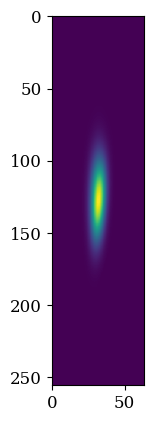

In [26]:
plt.imshow(distri2)

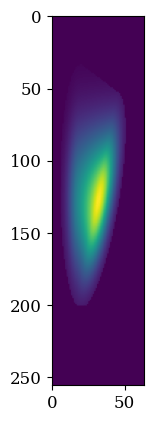

In [27]:
plt.imshow(distri1)

In [10]:
# Get the effective grating thickness
prob = total_weight / np.sum(total_weight)

# Get the distance for each pixel with respect to the propagation direction
volume = np.zeros((nx, ny, nz, 3))
volume[:, :, :, 0] = np.linspace(-nx * dx / 2, nx * dx / 2, num=nx)[:, np.newaxis, np.newaxis]
volume[:, :, :, 1] = np.linspace(-ny * dy / 2, ny * dy / 2, num=ny)[np.newaxis, :, np.newaxis]
volume[:, :, :, 2] = np.linspace(-nz * dz / 2, nz * dz / 2, num=nz)[np.newaxis, np.newaxis, :]

dist_pixel = np.dot(volume, surface_normal)
dist_pixel /= np.dot(kin_direction, surface_normal)

# Get the mean distance
dist_mean = np.sum(np.multiply(prob, dist_pixel))

In [11]:
dist_mean

6.11325276871513

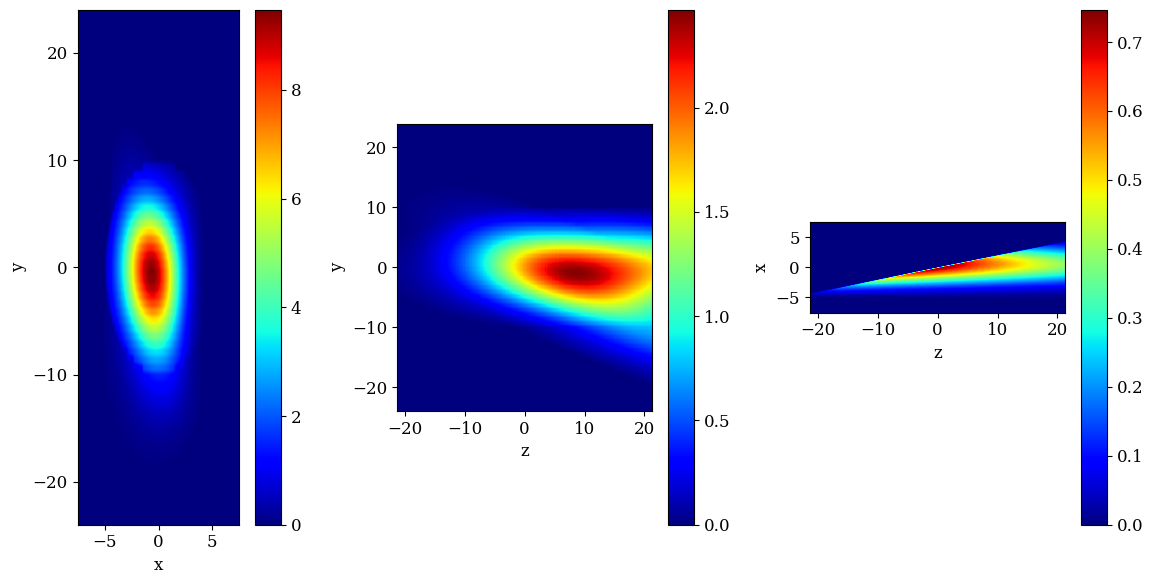

In [5]:
weight_xy = np.sum(total_weight, axis=-1)
weight_xz = np.sum(total_weight, axis=1)
weight_yz = np.sum(total_weight, axis=0)

fig, axes = plt.subplots(ncols=3, nrows=1)
fig.set_figheight(6)
fig.set_figwidth(12)
im1 = axes[0].imshow(weight_xy.T, extent=[-nx * dx / 2, nx * dx / 2, -ny * dy / 2, ny * dy / 2, ], cmap='jet',
                     origin='lower')
#im1 = axes[0].imshow(weight_xy.T, cmap='jet')
fig.colorbar(im1, ax=axes[0])
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")

im2 = axes[1].imshow(weight_yz, extent=[-nz * dz / 2, nz * dz / 2, -ny * dy / 2, ny * dy / 2, ], cmap='jet',
                     origin='lower')
#im2 = axes[1].imshow(weight_yz, cmap='jet')
fig.colorbar(im2, ax=axes[1])
axes[1].set_xlabel("z")
axes[1].set_ylabel("y")

im3 = axes[2].imshow(weight_xz, extent=[-nz * dz / 2, nz * dz / 2, -nx * dx / 2, nx * dx / 2], cmap='jet',
                     origin='lower')
#im3 = axes[2].imshow(weight_xz, cmap='jet')
fig.colorbar(im3, ax=axes[2])
axes[2].set_xlabel("z")
axes[2].set_ylabel("x")

plt.tight_layout()
plt.show()

In [6]:
# Get the scattering volume
scatter_volume = np.multiply(weight_pulse1 + weight_pulse2, weight_pulse3)
scatter_volume[weight_pulse1 > 100 * weight_pulse2] = 0
scatter_volume[weight_pulse2 > 100 * weight_pulse1] = 0
scatter_volume[weight_pulse3 < 1e-3 * np.max(weight_pulse3)] = 0

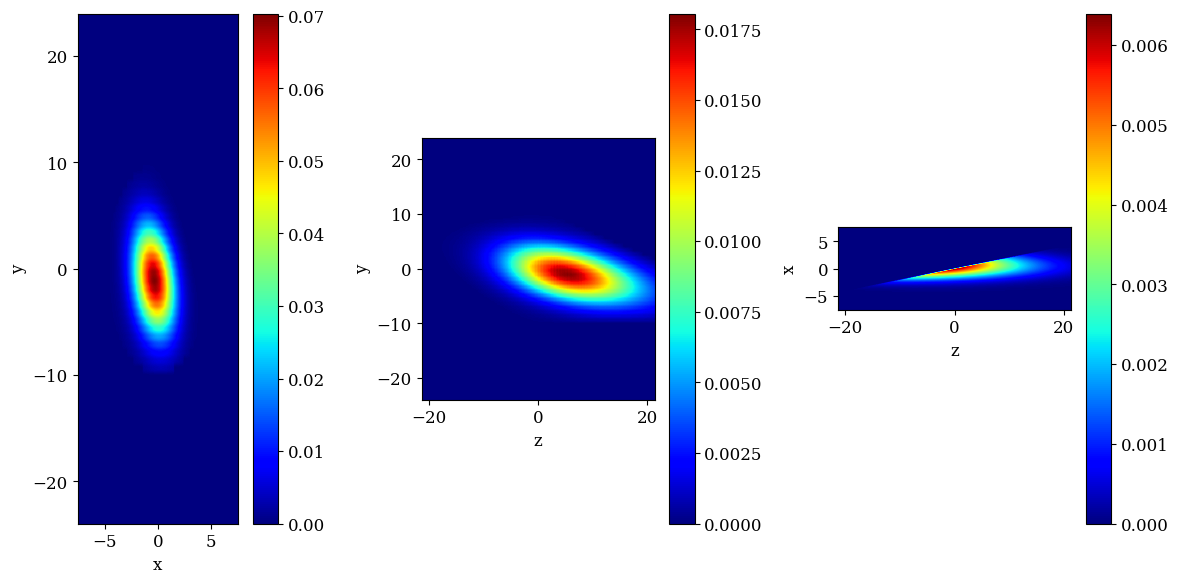

In [7]:
weight_xy = np.sum(scatter_volume, axis=-1)
weight_xz = np.sum(scatter_volume, axis=1)
weight_yz = np.sum(scatter_volume, axis=0)

fig, axes = plt.subplots(ncols=3, nrows=1)
fig.set_figheight(6)
fig.set_figwidth(12)
im1 = axes[0].imshow(weight_xy.T, extent=[-nx * dx / 2, nx * dx / 2, -ny * dy / 2, ny * dy / 2, ], cmap='jet',
                     origin='lower')
fig.colorbar(im1, ax=axes[0])
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")

im2 = axes[1].imshow(weight_yz, extent=[-nz * dz / 2, nz * dz / 2, -ny * dy / 2, ny * dy / 2, ], cmap='jet',
                     origin='lower')
fig.colorbar(im2, ax=axes[1])
axes[1].set_xlabel("z")
axes[1].set_ylabel("y")

im3 = axes[2].imshow(weight_xz, extent=[-nz * dz / 2, nz * dz / 2, -nx * dx / 2, nx * dx / 2], cmap='jet',
                     origin='lower')
fig.colorbar(im3, ax=axes[2])
axes[2].set_xlabel("z")
axes[2].set_ylabel("x")

plt.tight_layout()
plt.show()

In [8]:
## Get the volume assuming full coherence
volume_fft = np.square(np.abs(np.fft.fftshift(np.fft.fftn(scatter_volume))))

kx = np.fft.fftshift(np.fft.fftfreq(n=nx, d=dx)) * np.pi * 2  #/ 1e4
ky = np.fft.fftshift(np.fft.fftfreq(n=ny, d=dy)) * np.pi * 2  #/ 1e4
kz = np.fft.fftshift(np.fft.fftfreq(n=nz, d=dz)) * np.pi * 2  #/ 1e4

proj_yz_perfect = np.sum(volume_fft, axis=0)
proj_xz_perfect = np.sum(volume_fft, axis=1)
proj_xy_perfect = np.sum(volume_fft, axis=2)

In [9]:
g_vec = np.array([3.11361484, 3.2118638, -0.83751243]) * 1e4  # um^-1
g_dir = g_vec / np.linalg.norm(g_vec)
n_dir1 = np.array([g_vec[1], -g_vec[0], 0.])
n_dir1 /= np.linalg.norm(n_dir1)
n_dir2 = np.cross(g_dir, n_dir1)
n_dir2 /= np.linalg.norm(n_dir2)

# I would like to know what is the difference if there is a 5 mdeg angular difference
max_delta = np.linalg.norm(g_vec) * np.sin(np.deg2rad(3.7e-3))
# Therefore, one needs to consider the Q smearing along the normal direction of the g_vec
# Construct the Q average mask
q_vol = np.zeros((nx, ny, nz, 3))
q_vol[:, :, :, 0] = kx[:, np.newaxis, np.newaxis]
q_vol[:, :, :, 1] = ky[np.newaxis, :, np.newaxis]
q_vol[:, :, :, 2] = kz[np.newaxis, np.newaxis, :]

sigma_g_p = 0.1  # um
sigma_g_n = util.fwhm_to_sigma(2 * max_delta)  # um

q_weight = np.exp(- 0.5 * (np.dot(q_vol, g_dir) ** 2 / sigma_g_p ** 2 +
                           np.dot(q_vol, n_dir1) ** 2 / sigma_g_n ** 2 +
                           np.dot(q_vol, n_dir2) ** 2 / sigma_g_n ** 2))

q_weight /= np.sum(q_weight)

In [10]:
### Get the total volume
volume_total = sps.fftconvolve(volume_fft, q_weight, mode='same')

### Get the projection
proj_yz = np.sum(volume_total, axis=0)
proj_xz = np.sum(volume_total, axis=1)
proj_xy = np.sum(volume_total, axis=2)

In [18]:
# Get the wave-vectors
angle_num = 1000
angle_list = np.linspace(start=-np.deg2rad(0.05), stop=np.deg2rad(0.05), num=angle_num)

fit_x_m = np.array([6.40342603e-01, 5.06962809e-09]) * 1e4
fit_y_m = np.array([1.99944147e-01, -4.08478486e-07]) * 1e4
fit_z_m = np.array([3.14738445e+00, 2.49180183e-08]) * 1e4

fit_qx_m = angle_list * fit_x_m[0] + fit_x_m[1]
fit_qy_m = angle_list * fit_y_m[0] + fit_y_m[1]
fit_qz_m = angle_list * fit_z_m[0] + fit_z_m[1]

q_list_m = np.zeros((angle_num, 3))
q_list_m[:, 0] = fit_qx_m
q_list_m[:, 1] = fit_qy_m
q_list_m[:, 2] = fit_qz_m

from scipy.interpolate import RegularGridInterpolator

interp = RegularGridInterpolator((kx, ky, kz), volume_total, bounds_error=False, fill_value=None)
rock_m_mosaic = interp(q_list_m)

interp = RegularGridInterpolator((kx, ky, kz), volume_fft, bounds_error=False, fill_value=None)
rock_m_ideal = interp(q_list_m)


In [12]:
# Get the wave-vectors
angle_num = 1000
angle_list = np.linspace(start=-np.deg2rad(0.05), stop=np.deg2rad(0.05), num=angle_num)

fit_x_p = np.array([6.41086802e-01, 3.20573762e-09]) * 1e4
fit_y_p = np.array([1.26433034e-01, -4.08953214e-07]) * 1e4
fit_z_p = np.array([3.15104230e+00, 1.57567036e-08]) * 1e4

fit_qx_p = angle_list * fit_x_p[0] + fit_x_p[1]
fit_qy_p = angle_list * fit_y_p[0] + fit_y_p[1]
fit_qz_p = angle_list * fit_z_p[0] + fit_z_p[1]

q_list_p = np.zeros((angle_num, 3))
q_list_p[:, 0] = fit_qx_p
q_list_p[:, 1] = fit_qy_p
q_list_p[:, 2] = fit_qz_p

from scipy.interpolate import RegularGridInterpolator

interp = RegularGridInterpolator((kx, ky, kz), volume_total, bounds_error=False, fill_value=None)
rock_p_mosaic = interp(q_list_p)

interp = RegularGridInterpolator((kx, ky, kz), volume_fft, bounds_error=False, fill_value=None)
rock_p_ideal = interp(q_list_p)

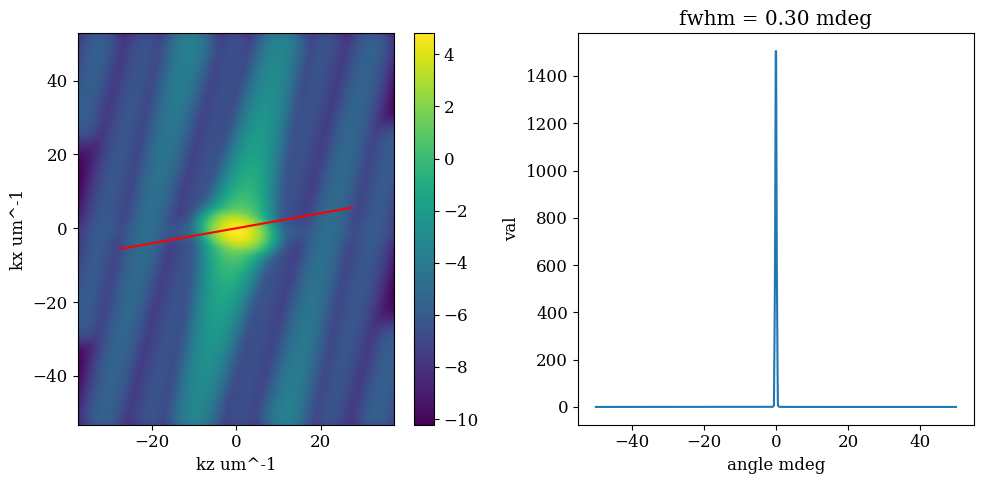

In [15]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))

#img1 = axes[0].imshow(np.log(proj_xz), vmax=-16, vmin=-25, extent=[kz[0], kz[-1], kx[0], kx[-1]], aspect='auto')
img1 = axes[0].imshow(np.log(proj_xz), extent=[kz[0], kz[-1], kx[0], kx[-1]], aspect='auto')
fig.colorbar(img1, ax=axes[0])
axes[0].plot(fit_qz_m, fit_qx_m, c='r')
axes[0].set_xlabel("kz um^-1")
axes[0].set_ylabel("kx um^-1")

axes[1].plot(np.rad2deg(angle_list) * 1e3, rock_m_mosaic)
axes[1].set_xlabel("angle mdeg")
axes[1].set_ylabel("val")
fwhm = util.get_fwhm(coordinate=np.rad2deg(angle_list) * 1e3, curve_values=rock_m_mosaic)
axes[1].set_title("fwhm = {:.2f} mdeg".format(fwhm))

plt.tight_layout()
plt.savefig("rocking_fit.png", dpi=300, bbox_inches='tight')
plt.show()

# Load the rocking curve measurement

In [16]:
rocking_9nm = np.load(r"G:\Shared drives\L10237-TG-10nm\All Document\appendix\crystal imperfection\9nm_rocking_I.npy")
theta_9nm = np.load(r"G:\Shared drives\L10237-TG-10nm\All Document\appendix\crystal imperfection\9nm_rocking_theta.npy")

rocking_12_p = np.load(
    r"G:\Shared drives\L10237-TG-10nm\All Document\appendix\crystal imperfection\12nm_right_rocking_I.npy")
theta_12_p = np.load(
    r"G:\Shared drives\L10237-TG-10nm\All Document\appendix\crystal imperfection\12nm_right_rocking_theta.npy")

rocking_12_m = np.load(r"G:\Shared drives\L10237-TG-10nm\All Document\appendix\crystal imperfection\12nm_rocking_I.npy")
theta_12_m = np.load(
    r"G:\Shared drives\L10237-TG-10nm\All Document\appendix\crystal imperfection\12nm_rocking_theta.npy")

bragg_measure = np.load(
    r"G:\Shared drives\L10237-TG-10nm\All Document\appendix\crystal imperfection\rocking_sto220.npy")
bragg_theta_measure = np.load(
    r"G:\Shared drives\L10237-TG-10nm\All Document\appendix\crystal imperfection\sam_th_sto220.npy")

# Load the imperfect fitting
imperfect_rocking = np.load("theory_sto220_rocking_imperfect.npy")
imperfect_rocking_theta = np.load("theory_sto220_theta_imperfect.npy")

perfect_rocking = np.load("perfect_sto220_rocking.npy")
perfect_rocking_theta = np.load("perfect_sto220_theta.npy")

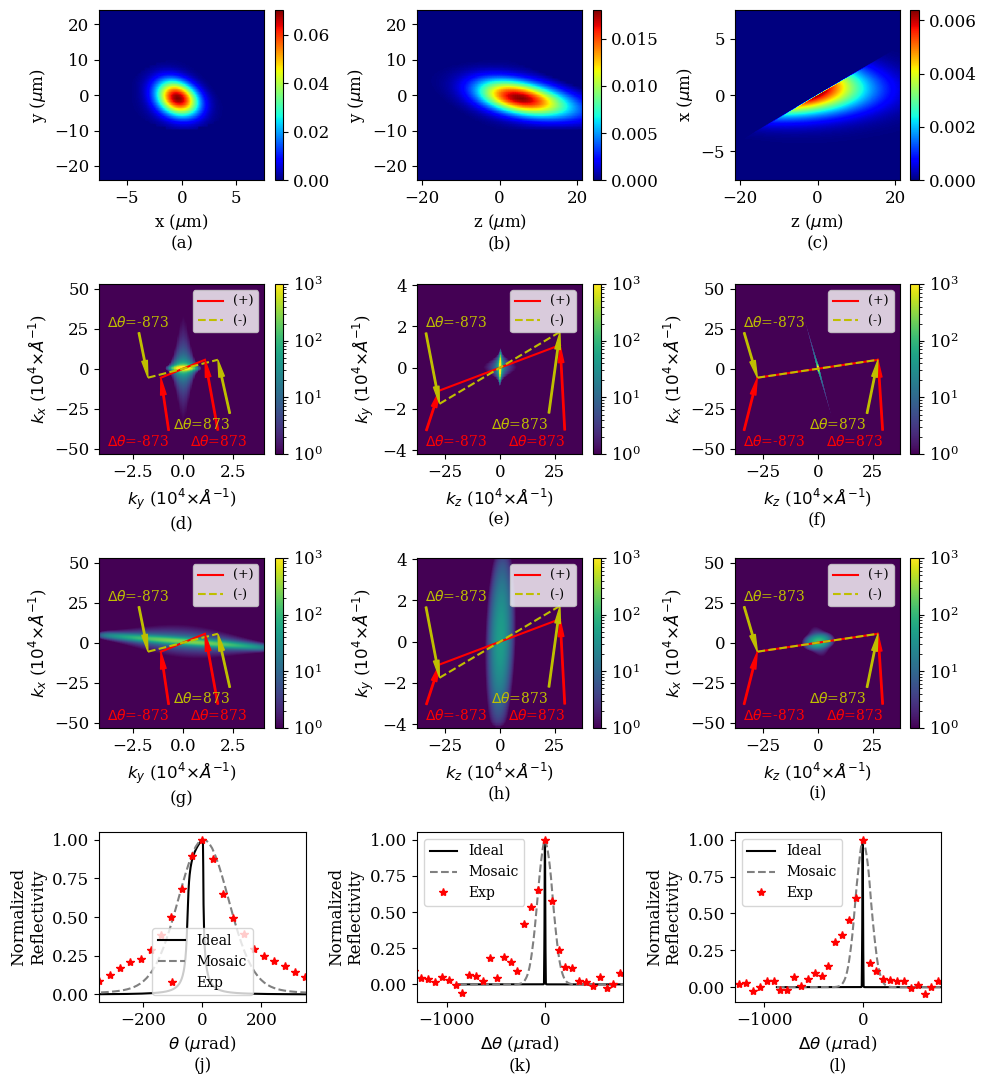

In [28]:
fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(10, 11))

# TODO: Convert the color map to the average total flux
# The first row shows the projection of the illumination volume
im1 = axes[0, 0].imshow(weight_xy.T, extent=[-nx * dx / 2, nx * dx / 2, -ny * dy / 2, ny * dy / 2, ], cmap='jet',
                        origin='lower', aspect='auto')
fig.colorbar(im1, ax=axes[0, 0])
axes[0, 0].set_xlabel("x ($\mu$m)\n(a)")
axes[0, 0].set_ylabel("y ($\mu$m)")

im2 = axes[0, 1].imshow(weight_yz, extent=[-nz * dz / 2, nz * dz / 2, -ny * dy / 2, ny * dy / 2, ], cmap='jet',
                        origin='lower', aspect='auto')
fig.colorbar(im2, ax=axes[0, 1])
axes[0, 1].set_xlabel("z ($\mu$m)\n(b)")
axes[0, 1].set_ylabel("y ($\mu$m)")

im3 = axes[0, 2].imshow(weight_xz, extent=[-nz * dz / 2, nz * dz / 2, -nx * dx / 2, nx * dx / 2], cmap='jet',
                        origin='lower', aspect='auto')
fig.colorbar(im3, ax=axes[0, 2])
axes[0, 2].set_xlabel("z ($\mu$m)\n(c)")
axes[0, 2].set_ylabel("x ($\mu$m)")

# The third row shows the projection of the reciprocal space
vmin = 1
vmax = 1e3
img1 = axes[1, 0].imshow(np.abs(proj_xy_perfect), extent=[ky[0], ky[-1], kx[0], kx[-1]], aspect='auto', origin='lower',
                         norm=LogNorm(vmin=vmin, vmax=vmax))
fig.colorbar(img1, ax=axes[1, 0])
axes[1, 0].plot(fit_qy_p, fit_qx_p, c='r', label='(+)')
axes[1, 0].plot(fit_qy_m, fit_qx_m, c='y', linestyle='--', label='(-)')
axes[1, 0].set_xlabel(r"$k_y$ ($10^4$$\times$$\AA^{-1}$)"+"\n(d)")
axes[1, 0].set_ylabel(r"$k_x$ ($10^4$$\times$$\AA^{-1}$)")

img2 = axes[1, 1].imshow(np.abs(proj_yz_perfect), extent=[kz[0], kz[-1], ky[0], ky[-1]], aspect='auto', origin='lower',
                         norm=LogNorm(vmin=vmin, vmax=vmax))
fig.colorbar(img2, ax=axes[1, 1])
axes[1, 1].plot(fit_qz_p, fit_qy_p, c='r', label='(+)')
axes[1, 1].plot(fit_qz_m, fit_qy_m, c='y', linestyle='--', label='(-)')
axes[1, 1].set_xlabel(r"$k_z$ ($10^4$$\times$$\AA^{-1}$)"+"\n(e)")
axes[1, 1].set_ylabel(r"$k_y$ ($10^4$$\times$$\AA^{-1}$)")

img3 = axes[1, 2].imshow(np.abs(proj_xz_perfect), extent=[kz[0], kz[-1], kx[0], kx[-1]], aspect='auto', origin='lower',
                         norm=LogNorm(vmin=vmin, vmax=vmax))
fig.colorbar(img3, ax=axes[1, 2])
axes[1, 2].plot(fit_qz_p, fit_qx_p, c='r', label='(+)')
axes[1, 2].plot(fit_qz_m, fit_qx_m, c='y', linestyle='--', label='(-)')
axes[1, 2].set_xlabel(r"$k_z$ ($10^4$$\times$$\AA^{-1}$)"+"\n(f)")
axes[1, 2].set_ylabel(r"$k_x$ ($10^4$$\times$$\AA^{-1}$)")

# The second row shows the projection of the reciprocal space
img1 = axes[2, 0].imshow(np.abs(proj_xy), extent=[ky[0], ky[-1], kx[0], kx[-1]], aspect='auto', origin='lower',
                         norm=LogNorm(vmin=vmin, vmax=vmax))
fig.colorbar(img1, ax=axes[2, 0])
axes[2, 0].plot(fit_qy_p, fit_qx_p, c='r', label='(+)')
axes[2, 0].plot(fit_qy_m, fit_qx_m, c='y', linestyle='--', label='(-)')
axes[2, 0].set_xlabel(r"$k_y$ ($10^4$$\times$$\AA^{-1}$)"+"\n(g)")
axes[2, 0].set_ylabel(r"$k_x$ ($10^4$$\times$$\AA^{-1}$)")

img2 = axes[2, 1].imshow(np.abs(proj_yz), extent=[kz[0], kz[-1], ky[0], ky[-1]], aspect='auto', origin='lower',
                         norm=LogNorm(vmin=vmin, vmax=vmax))
fig.colorbar(img2, ax=axes[2, 1])
axes[2, 1].plot(fit_qz_p, fit_qy_p, c='r', label='(+)')
axes[2, 1].plot(fit_qz_m, fit_qy_m, c='y', linestyle='--', label='(-)')
axes[2, 1].set_xlabel(r"$k_z$ ($10^4$$\times$$\AA^{-1}$)"+"\n(h)")
axes[2, 1].set_ylabel(r"$k_y$ ($10^4$$\times$$\AA^{-1}$)")

img3 = axes[2, 2].imshow(np.abs(proj_xz), extent=[kz[0], kz[-1], kx[0], kx[-1]], aspect='auto', origin='lower',
                         norm=LogNorm(vmin=vmin, vmax=vmax))
fig.colorbar(img3, ax=axes[2, 2])
axes[2, 2].plot(fit_qz_p, fit_qx_p, c='r', label='(+)')
axes[2, 2].plot(fit_qz_m, fit_qx_m, c='y', linestyle='--', label='(-)')
axes[2, 2].set_xlabel(r"$k_z$ ($10^4$$\times$$\AA^{-1}$)"+"\n(i)")
axes[2, 2].set_ylabel(r"$k_x$ ($10^4$$\times$$\AA^{-1}$)")

position_p_list = [[fit_qy_p, fit_qx_p],
                   [fit_qz_p, fit_qy_p],
                   [fit_qz_p, fit_qx_p], ]
position_m_list = [[fit_qy_m, fit_qx_m],
                   [fit_qz_m, fit_qy_m],
                   [fit_qz_m, fit_qx_m], ]

for idx in [1, 2]:
    for idx1 in [0, 1, 2]:
        axes[idx, idx1].legend(loc='upper right', fontsize=9)
        axes[idx, idx1].annotate(r'$\Delta\theta$={:.0f}'.format(angle_list[0] * 1e6),
                                 xy=(position_p_list[idx1][0][0], position_p_list[idx1][1][0]),  # theta, radius
                                 xytext=(0.05, 0.05),  # fraction, fraction
                                 textcoords='axes fraction',
                                 arrowprops=dict(facecolor='red', edgecolor='red', shrink=0.01, width=1, headwidth=4),
                                 color='r',
                                 fontsize=10,
                                 )
        axes[idx, idx1].annotate(r'$\Delta\theta$={:.0f}'.format(angle_list[-1] * 1e6),
                                 xy=(position_p_list[idx1][0][-1], position_p_list[idx1][1][-1]),  # theta, radius
                                 xytext=(0.55, 0.05),  # fraction, fraction
                                 textcoords='axes fraction',
                                 arrowprops=dict(facecolor='red', edgecolor='red', shrink=0.01, width=1, headwidth=4),
                                 color='red',
                                 fontsize=10,
                                 )

        axes[idx, idx1].annotate(r'$\Delta\theta$={:.0f}'.format(angle_list[0] * 1e6),
                                 xy=(position_m_list[idx1][0][0], position_m_list[idx1][1][0]),  # theta, radius
                                 xytext=(0.05, 0.75),  # fraction, fraction
                                 textcoords='axes fraction',
                                 arrowprops=dict(facecolor='y', edgecolor='y', shrink=0.01, width=1, headwidth=4),
                                 color='y',
                                 fontsize=10,
                                 )

        axes[idx, idx1].annotate(r'$\Delta\theta$={:.0f}'.format(angle_list[-1] * 1e6),
                                 xy=(position_m_list[idx1][0][-1], position_m_list[idx1][1][-1]),  # theta, radius
                                 xytext=(0.45, 0.15),  # fraction, fraction
                                 textcoords='axes fraction',
                                 arrowprops=dict(facecolor='y', edgecolor='y', shrink=0.01, width=1, headwidth=4),
                                 color='y',
                                 fontsize=10,
                                 )

# The 4th row shows the rocking curve
offset = perfect_rocking_theta[np.argmax(perfect_rocking)]
axes[3, 0].plot((perfect_rocking_theta - offset) * 1e6,
                perfect_rocking / np.max(perfect_rocking),
                linestyle='-', color='black', label='Ideal')

offset = imperfect_rocking_theta[np.argmax(imperfect_rocking)]
axes[3, 0].plot((imperfect_rocking_theta - offset) * 1e6,
                imperfect_rocking / np.max(imperfect_rocking),
                linestyle='--', color='grey', label='Mosaic')

offset = bragg_theta_measure[np.argmax(bragg_measure[0])]
axes[3, 0].plot(np.deg2rad(bragg_theta_measure - offset) * 1e6,
                bragg_measure[0] / np.max(bragg_measure[0]),
                linestyle='', marker='*', color='r', label='Exp')
axes[3, 0].legend(loc='lower center', fontsize=10, )
axes[3, 0].set_xlim([-350, 350])
axes[3, 0].set_xlabel(r"$\theta$ ($\mu$rad)"+"\n(j)")
axes[3, 0].set_ylabel("Normalized\nReflectivity")


# Rocking curve comparison
offset = angle_list[np.argmax(rock_p_ideal)]
axes[3, 1].plot((angle_list - offset) * 1e6,
                rock_p_ideal / np.max(rock_p_ideal),
                linestyle='-', marker='', color='black', label='Ideal')

offset = angle_list[np.argmax(rock_p_mosaic)]
axes[3, 1].plot((angle_list - offset) * 1e6,
                rock_p_mosaic / np.max(rock_p_mosaic),
                linestyle='--', marker='', color='grey', label='Mosaic')

offset = theta_12_p[np.argmax(rocking_12_p)]
axes[3, 1].plot(np.deg2rad(theta_12_p - offset) * 1e6,
                rocking_12_p / np.max(rocking_12_p),
                linestyle='', marker='*', color='r', label='Exp')


axes[3, 1].legend(loc='upper left', fontsize=10, )
axes[3, 1].set_xlim([-1300, 800])
axes[3, 1].set_xlabel(r"$\Delta\theta$ ($\mu$rad)"+"\n(k)")
axes[3, 1].set_ylabel("Normalized\nReflectivity")


# Rocking curve comparison
offset = angle_list[np.argmax(rock_m_ideal)]
axes[3, 2].plot((angle_list - offset) * 1e6,
                rock_m_ideal / np.max(rock_m_ideal),
                linestyle='-', marker='', color='black', label='Ideal')

offset = angle_list[np.argmax(rock_m_mosaic)]
axes[3, 2].plot((angle_list - offset) * 1e6,
                rock_m_mosaic / np.max(rock_m_mosaic),
                linestyle='--', marker='', color='grey', label='Mosaic')

offset = theta_12_m[np.argmax(rocking_12_m)]
axes[3, 2].plot(np.deg2rad(theta_12_m - offset) * 1e6,
                rocking_12_m / np.max(rocking_12_m),
                linestyle='', marker='*', color='r', label='Exp')


axes[3, 2].legend(loc='upper left', fontsize=10, )
axes[3, 2].set_xlim([-1300, 800])
axes[3, 2].set_xlabel(r"$\Delta\theta$ ($\mu$rad)"+"\n(l)")
axes[3, 2].set_ylabel("Normalized\nReflectivity")


plt.tight_layout()
plt.savefig("rocking_fit.png", dpi=300, bbox_inches='tight')
plt.show()

In [3]:
np.deg2rad(7e-3) * 1e6

122.17304763960306